## 1. Import pakages

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import plotly
import chart_studio.plotly as py
import plotly.express as px
import cufflinks as cf
cf.go_offline()

import os
import tqdm
import requests
from datetime import datetime, timedelta
import time

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing

import lightgbm as lgb

In [2]:
plt.rcParams['font.sans-serif']=['SimHei'] #用來正常顯示中文標簽
plt.rcParams['axes.unicode_minus']=False #用來正常顯示負號

## 2. Data reading and preprocessing

In [3]:
path_data = r'C:\Users\patri\Taipower\data'

path_data_loadarea = os.path.join(path_data, 'loadarea')
path_data_forecast = os.path.join(path_data, 'forecast')

### 2.1 Energy data

In [4]:
loadarea = pd.DataFrame()

for file in tqdm.tqdm(os.listdir(path_data_loadarea)):
    df_temp = pd.read_csv(os.path.join(path_data_loadarea, file))
    loadarea = pd.concat([loadarea, df_temp], axis=0, ignore_index=True)

loadarea = loadarea.pivot_table(columns='area',index='datetime',values='load')
loadarea.index= pd.to_datetime(loadarea.index)
loadarea.columns = 'load_'+loadarea.columns

loadarea['load_total'] = loadarea['load_north']+ loadarea['load_east']+ loadarea['load_central']+ loadarea['load_south']


loadarea

100%|██████████████████████████████████████████████████████████████████████████████| 1946/1946 [00:24<00:00, 78.74it/s]


area,load_central,load_east,load_north,load_south,load_total
datetime,,,,,
2017-01-01 00:00:00,567.0,33.2,677.8,696.2,1974.2
2017-01-01 00:10:00,553.1,32.9,671.6,695.2,1952.8
2017-01-01 00:20:00,568.2,33.3,672.2,695.1,1968.8
2017-01-01 00:30:00,553.2,33.6,672.4,684.3,1943.5
2017-01-01 00:40:00,563.7,32.6,658.2,696.6,1951.1
...,...,...,...,...,...
2022-07-01 23:10:00,951.4,43.9,1139.3,1056.0,3190.6
2022-07-01 23:20:00,941.5,43.7,1125.7,1055.6,3166.5
2022-07-01 23:30:00,928.8,43.2,1125.1,1053.4,3150.5


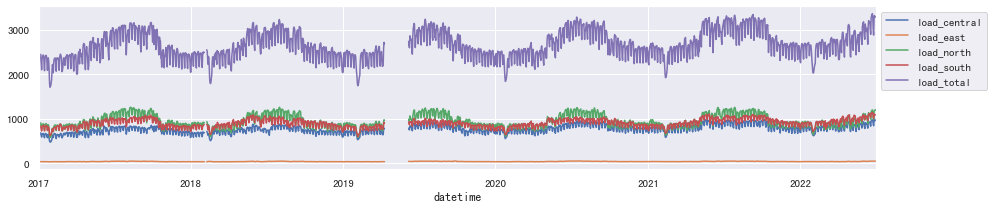

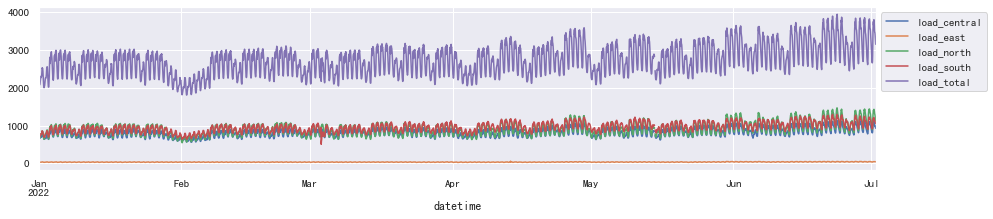

In [5]:
#loadarea.resample('D').mean().iplot()
#loadarea.loc['2020':].resample('H').mean().iplot()
loadarea.resample('D').mean().plot(figsize=(15,3))
plt.legend(bbox_to_anchor=(1.00, 1.00))
loadarea.loc['2022':].resample('H').mean().plot(figsize=(15,3))
plt.legend(bbox_to_anchor=(1.00, 1.00))

### 2.2 Weather data

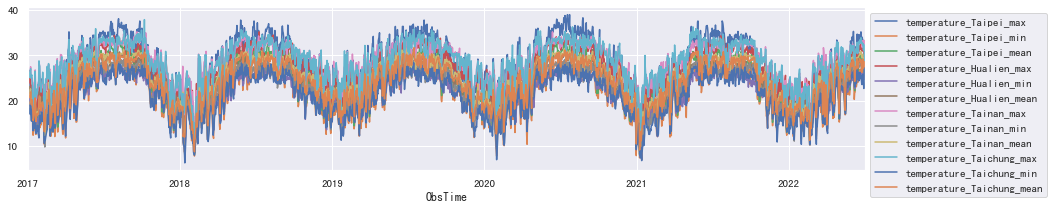

In [6]:
weatherData = pd.read_csv(os.path.join(path_data, 'weatherData_20170101-20220701.csv'), encoding='utf8')
temperatureData = weatherData.pivot_table(index='ObsTime',columns='station',values='Temperature')
temperatureData = temperatureData.rename(columns={'466920_臺北':'Taipei','466990_花蓮':'Hualien',
                                                  '467410_臺南':'Tainan','467490_臺中':'Taichung'})
temperatureData.index = pd.to_datetime(temperatureData.index)
temperatureData.columns = 'temperature_'+temperatureData.columns
temperatureData = temperatureData.resample('D').agg(['max','min','mean'])
temperatureData.columns = temperatureData.columns.get_level_values(0)+'_'+temperatureData.columns.get_level_values(1)

#temperatureData.iplot()
temperatureData.plot(figsize=(15,3))
plt.legend(bbox_to_anchor=(1.00, 1.00))

### 2.3 Calendar data

In [7]:
url = 'https://data.ntpc.gov.tw/api/datasets/308DCD75-6434-45BC-A95F-584DA4FED251/csv/file'
df_holiday = pd.read_csv(url)
df_holiday = df_holiday.rename(columns={'name':'holiday_name', 'description':'holiday_description'})

df_holiday

,date,holiday_name,isHoliday,holidayCategory,holiday_description
0,2013/1/1,中華民國開國紀念日,是,放假之紀念日及節日,全國各機關學校放假一日。
1,2013/1/5,NaN,是,星期六、星期日,NaN
2,2013/1/6,NaN,是,星期六、星期日,NaN
3,2013/1/12,NaN,是,星期六、星期日,NaN
4,2013/1/13,NaN,是,星期六、星期日,NaN
...,...,...,...,...,...
1188,2022/12/17,NaN,是,星期六、星期日,NaN
1189,2022/12/18,NaN,是,星期六、星期日,NaN
1190,2022/12/24,NaN,是,星期六、星期日,NaN
1191,2022/12/25,NaN,是,星期六、星期日,NaN


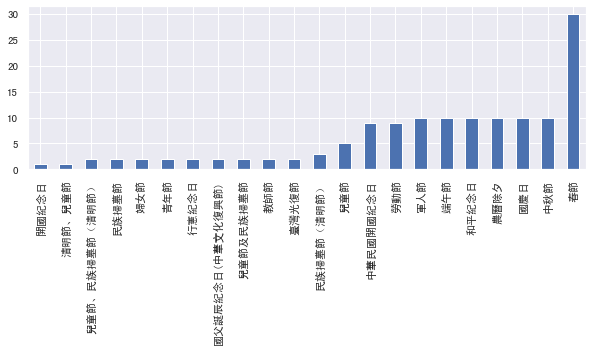

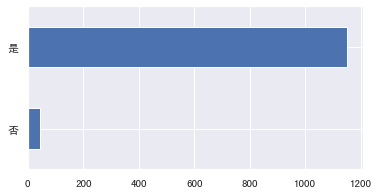

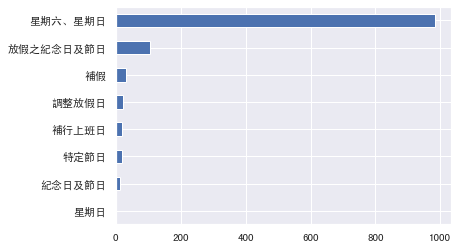

In [8]:
#df_holiday['holiday_name'].value_counts(ascending=True).iplot(kind='barh')
#df_holiday['isHoliday'].value_counts(ascending=True).iplot(kind='barh')
#df_holiday['holidayCategory'].value_counts(ascending=True).iplot(kind='barh')

df_holiday['holiday_name'].value_counts(ascending=True).plot(kind='bar',figsize=(10,3))
plt.show()
df_holiday['isHoliday'].value_counts(ascending=True).plot(kind='barh',figsize=(6,3))
plt.show()
df_holiday['holidayCategory'].value_counts(ascending=True).plot(kind='barh')
plt.show()

In [9]:
df_holiday['date'] = pd.to_datetime(df_holiday['date'])
df_holiday = df_holiday.set_index('date').asfreq('D')
df_holiday = df_holiday.reset_index()

df_holiday['holiday_name'] = preprocessing.LabelEncoder().fit_transform(df_holiday['holiday_name'].astype('str'))
df_holiday['isHoliday'] = preprocessing.LabelEncoder().fit_transform(df_holiday['isHoliday'].astype('str'))
df_holiday['holidayCategory'] = preprocessing.LabelEncoder().fit_transform(df_holiday['holidayCategory'].astype('str'))
df_holiday['holiday_description'] = preprocessing.LabelEncoder().fit_transform(df_holiday['holiday_description'].astype('str'))


df_holiday

,date,holiday_name,isHoliday,holidayCategory,holiday_description
0,2013-01-01,2,2,1,7
1,2013-01-02,0,0,0,1
2,2013-01-03,0,0,0,1
3,2013-01-04,0,0,0,1
4,2013-01-05,0,2,2,1
...,...,...,...,...,...
3647,2022-12-27,0,0,0,1
3648,2022-12-28,0,0,0,1
3649,2022-12-29,0,0,0,1
3650,2022-12-30,0,0,0,1


### 2.4 Merge datasets and create features

In [10]:
df_dataset = loadarea.copy()


index_temp = df_dataset.index.copy()

df_dataset['date'] = pd.to_datetime(df_dataset.index.date)
df_dataset['year'] = df_dataset.index.year.astype('int')
df_dataset['weekday'] = df_dataset.index.weekday
df_dataset['hour'] = df_dataset.index.hour + df_dataset.index.minute/60
df_dataset['timeofweek'] = df_dataset['hour'] + df_dataset['weekday']*24

df_dataset = df_dataset.merge(temperatureData.reset_index(), left_on='date', right_on='ObsTime')
df_dataset = df_dataset.merge(df_holiday, on='date')
df_dataset = df_dataset.drop('date',axis=1)
df_dataset.index = index_temp

df_dataset['temperature_mean']=df_dataset[['temperature_Taipei_mean', 'temperature_Tainan_mean', 'temperature_Taichung_mean']].mean(axis=1)

df_dataset

,load_central,load_east,load_north,load_south,load_total,year,weekday,hour,timeofweek,ObsTime,...,temperature_Tainan_min,temperature_Tainan_mean,temperature_Taichung_max,temperature_Taichung_min,temperature_Taichung_mean,holiday_name,isHoliday,holidayCategory,holiday_description,temperature_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,567.0,33.2,677.8,696.2,1974.2,2017,6,0.000000,144.000000,2017-01-01,...,17.9,20.956522,25.6,15.8,20.047826,2,2,1,29,21.243478
2017-01-01 00:10:00,553.1,32.9,671.6,695.2,1952.8,2017,6,0.166667,144.166667,2017-01-01,...,17.9,20.956522,25.6,15.8,20.047826,2,2,1,29,21.243478
2017-01-01 00:20:00,568.2,33.3,672.2,695.1,1968.8,2017,6,0.333333,144.333333,2017-01-01,...,17.9,20.956522,25.6,15.8,20.047826,2,2,1,29,21.243478
2017-01-01 00:30:00,553.2,33.6,672.4,684.3,1943.5,2017,6,0.500000,144.500000,2017-01-01,...,17.9,20.956522,25.6,15.8,20.047826,2,2,1,29,21.243478
2017-01-01 00:40:00,563.7,32.6,658.2,696.6,1951.1,2017,6,0.666667,144.666667,2017-01-01,...,17.9,20.956522,25.6,15.8,20.047826,2,2,1,29,21.243478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-01 23:10:00,951.4,43.9,1139.3,1056.0,3190.6,2022,4,23.166667,119.166667,2022-07-01,...,26.1,28.791667,32.3,26.5,28.604167,0,0,0,1,29.218056
2022-07-01 23:20:00,941.5,43.7,1125.7,1055.6,3166.5,2022,4,23.333333,119.333333,2022-07-01,...,26.1,28.791667,32.3,26.5,28.604167,0,0,0,1,29.218056
2022-07-01 23:30:00,928.8,43.2,1125.1,1053.4,3150.5,2022,4,23.500000,119.500000,2022-07-01,...,26.1,28.791667,32.3,26.5,28.604167,0,0,0,1,29.218056


## 3. Modeling

### 3.1 Our first model: temporal and weather feature

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='timeofweek', ylabel='load_total'>

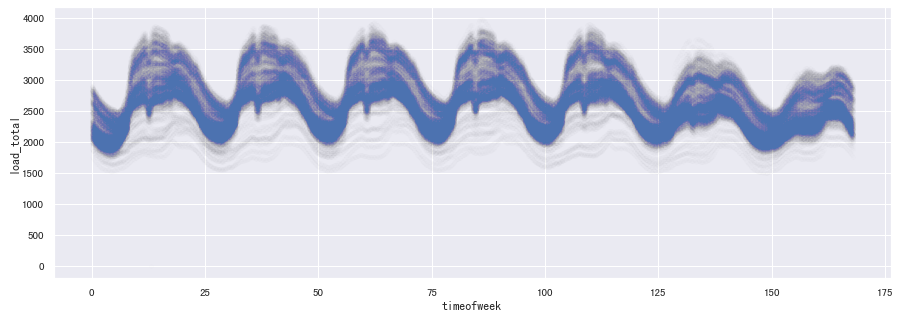

In [11]:
df_dataset.plot(kind='scatter',x='timeofweek',y='load_total', figsize=(15,5),alpha=0.005)

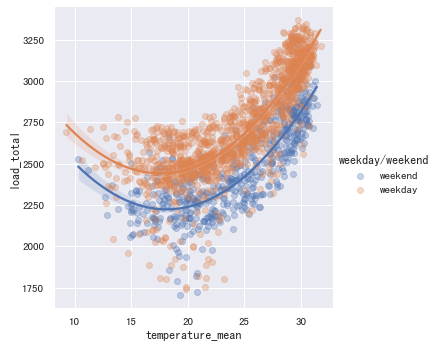

In [12]:
# Scatter plot for demand and outdoor temperature
df_plot = df_dataset.resample('D').mean().copy()
df_plot['weekday/weekend'] = 'weekday'
df_plot.loc[df_plot['weekday']>4, 'weekday/weekend'] ='weekend'

sns.lmplot(x='temperature_mean', y='load_total', hue="weekday/weekend",
           data=df_plot, order=2, scatter_kws={'alpha':0.3})

In [13]:
list_feat = ['weekday','hour','temperature_mean']

R SQUARED: 0.691
MAE: 215.827


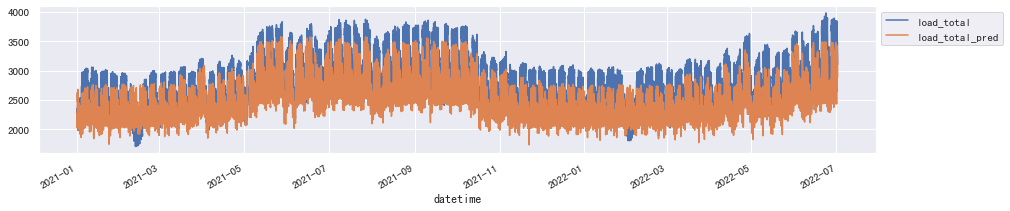

In [14]:
traindata = df_dataset.loc[:'2020'].copy()
testdata = df_dataset.loc['2021':].copy()

LGB_model = lgb.LGBMRegressor()
LGB_model.fit(traindata[list_feat], traindata['load_total'])

testdata['load_total_pred'] = LGB_model.predict(testdata[list_feat])

errors = abs(testdata['load_total_pred'] - testdata['load_total'])

RSQUARED = r2_score(testdata['load_total'], testdata['load_total_pred'])
MAE = mean_absolute_error(testdata['load_total'], testdata['load_total_pred'])

print("R SQUARED: "+str(round(RSQUARED,3)))
print("MAE: "+str(round(MAE,3)))

#testdata[['load_total', 'load_total_pred']].iplot()
testdata[['load_total', 'load_total_pred']].plot(figsize=(15,3))
plt.legend(bbox_to_anchor=(1.00, 1.00))

### 3.2 The 2nd model: add calendar data

C:\Users\patri\AppData\Roaming\Python\Python37\site-packages\seaborn\categorical.py:1296: UserWarning:

66.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

C:\Users\patri\AppData\Roaming\Python\Python37\site-packages\seaborn\categorical.py:1296: UserWarning:

33.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



<AxesSubplot:xlabel='isHoliday', ylabel='load_total'>

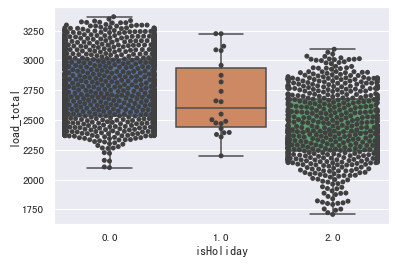

In [15]:
# Scatter plot for demand and Google Trend
df_plot = df_dataset.resample('D').mean().copy()

sns.boxplot(x="isHoliday", y='load_total', data=df_plot)
sns.swarmplot(x="isHoliday", y='load_total', data=df_plot, color=".25")

In [16]:
list_feat = ['weekday','hour','temperature_mean', 
             'holiday_name','isHoliday','holidayCategory']

R SQUARED: 0.756
MAE: 195.939


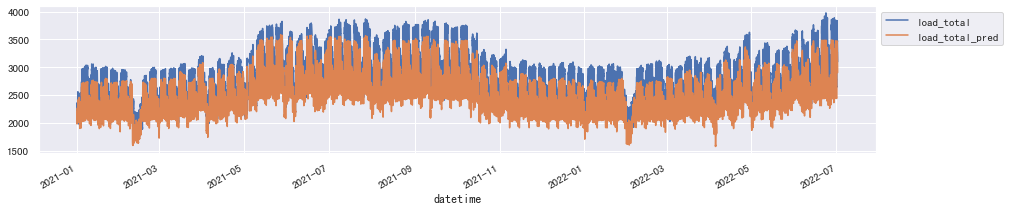

In [17]:
traindata = df_dataset.loc[:'2020'].copy()
testdata = df_dataset.loc['2021':].copy()

LGB_model = lgb.LGBMRegressor()
LGB_model.fit(traindata[list_feat], traindata['load_total'])

testdata['load_total_pred'] = LGB_model.predict(testdata[list_feat])

errors = abs(testdata['load_total_pred'] - testdata['load_total'])

RSQUARED = r2_score(testdata['load_total'], testdata['load_total_pred'])
MAE = mean_absolute_error(testdata['load_total'], testdata['load_total_pred'])

print("R SQUARED: "+str(round(RSQUARED,3)))
print("MAE: "+str(round(MAE,3)))

#testdata[['load_total', 'load_total_pred']].iplot()
testdata[['load_total', 'load_total_pred']].plot(figsize=(15,3))
plt.legend(bbox_to_anchor=(1.00, 1.00))

### 3.3 The 3rd model: add growth rate

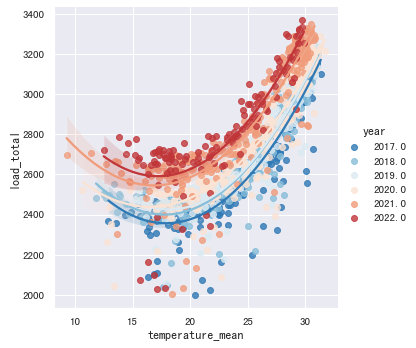

In [18]:
df_plot = df_dataset.resample('D').mean().copy()
df_plot['weekday/weekend'] = 'weekday'
df_plot.loc[df_plot['weekday']>4, 'weekday/weekend'] ='weekend'
df_plot = df_plot[df_plot['weekday/weekend']=='weekday']
df_plot = df_plot[df_plot['load_total']>2000]

sns.lmplot(x='temperature_mean', y='load_total', hue='year',
           data=df_plot, order=2, palette='RdBu_r')

In [19]:
growth_rate = 0.025

In [20]:
df_dataset['delta_time'] = df_dataset.index.year + df_dataset.index.dayofyear/366 + df_dataset.index.hour/366/24
df_dataset['delta_time'] = df_dataset['delta_time'] - df_dataset['delta_time'].min()

df_dataset['load_total_untrended'] = df_dataset['load_total'] * (1-growth_rate*df_dataset['delta_time'])

In [21]:
list_feat = ['weekday','hour','temperature_mean', 
             'holiday_name','isHoliday','holidayCategory']

R SQUARED: 0.965
MAE: 57.458


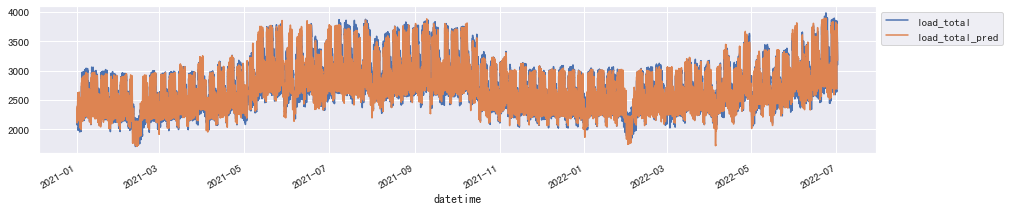

In [22]:
traindata = df_dataset.loc[:'2020'].copy()
testdata = df_dataset.loc['2021':].copy()


LGB_model = lgb.LGBMRegressor()
LGB_model.fit(traindata[list_feat], traindata['load_total_untrended'])

testdata['load_total_pred'] = LGB_model.predict(testdata[list_feat])
testdata['load_total_pred'] = testdata['load_total_pred'] / (1-growth_rate*testdata['delta_time'])

errors = abs(testdata['load_total_pred'] - testdata['load_total'])

RSQUARED = r2_score(testdata['load_total'], testdata['load_total_pred'])
MAE = mean_absolute_error(testdata['load_total'], testdata['load_total_pred'])

print("R SQUARED: "+str(round(RSQUARED,3)))
print("MAE: "+str(round(MAE,3)))

#testdata[['load_total', 'load_total_pred']].iplot()
testdata[['load_total', 'load_total_pred']].plot(figsize=(15,3))
plt.legend(bbox_to_anchor=(1.00, 1.00))

### 3.4 The 4th model: add lag feature

In [23]:
df_dataset['load_total_untrended_lastDay'] = df_dataset['load_total_untrended'].shift(24*6)

In [24]:
list_feat = ['weekday','hour','temperature_mean', 
             'holiday_name','isHoliday','holidayCategory',
             'load_total_untrended_lastDay']

R SQUARED: 0.981
MAE: 40.357


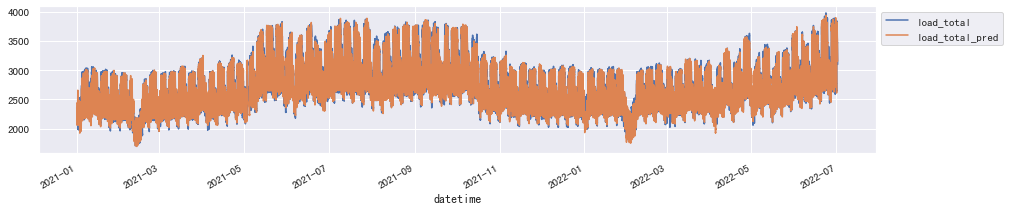

In [25]:
traindata = df_dataset.loc[:'2020'].copy()
testdata = df_dataset.loc['2021':].copy()


LGB_model = lgb.LGBMRegressor()
LGB_model.fit(traindata[list_feat], traindata['load_total_untrended'])

testdata['load_total_pred'] = LGB_model.predict(testdata[list_feat])
testdata['load_total_pred'] = testdata['load_total_pred'] / (1-growth_rate*testdata['delta_time'])

errors = abs(testdata['load_total_pred'] - testdata['load_total'])

RSQUARED = r2_score(testdata['load_total'], testdata['load_total_pred'])
MAE = mean_absolute_error(testdata['load_total'], testdata['load_total_pred'])

print("R SQUARED: "+str(round(RSQUARED,3)))
print("MAE: "+str(round(MAE,3)))

#testdata[['load_total', 'load_total_pred']].iplot()
testdata[['load_total', 'load_total_pred']].plot(figsize=(15,3))
plt.legend(bbox_to_anchor=(1.00, 1.00))